In [3]:
#Name : Manahil Sarwar
#Section : AI-K
#Roll No : 21I-0293

In [4]:
#Importing Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage.feature import hog
from skimage import color
from skimage.transform import resize
from sklearn.svm import SVC
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import regularizers
import tensorflow as tf
import shutil

# Question # 1

Part 1:
Preprocess the images and split into train and test directories

In [5]:
#Process an image to recognize different squares
def process_image(image_path,k):
    img=cv2.imread(image_path)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _,threshold=cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
    contours,_ =cv2.findContours(threshold,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    j=0
    min_area_threshold=300000
    min1_area_threshold=10000
    max_area_threshold=1000000
    for contour in contours:
        #Ignore the first contour (whole image)
        if i==0:
            i=1
            continue
        #Filter contours based on area
        area=cv2.contourArea(contour)
        approx=cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
        #Finding the center point of the shape
        M=cv2.moments(contour)
        if M['m00']!=0.0:
            x=int(M['m10']/M['m00'])
            y=int(M['m01']/M['m00'])
        #Check if the contour is a quadrilateral
        if len(approx)==4:
            if area>min1_area_threshold and area<min_area_threshold:
                k=k+1
            if area<min_area_threshold or area>max_area_threshold:
                continue
            #Draw the contour on the image
            cv2.drawContours(img,[contour],0,(0,0,255),5)
            #Get the bounding box around the contour
            x,y,w,h=cv2.boundingRect(contour)
            cropped_img=img[y:y+h,x:x+w]
            #Create a directory for the number if it doesn't exist
            directory = f'/content/signatures_directory/directory_{k}'
            if not os.path.exists(directory):
                os.makedirs(directory)
            #Save the cropped contour as an image in the appropriate directory
            cv2.imwrite(f'{directory}/square_{j}.png',cropped_img)
            j=j+1

    return j,k

#Main function to iterate over all images in a directory
def process_directory(directory_path):
    k=0
    for filename in os.listdir(directory_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path=os.path.join(directory_path,filename)
            print(f"Processing: {image_path}")
            j,k=process_image(image_path,k)

#Process all images in the directory
process_directory('/content/Data/Data')

Processing: /content/Data/Data/20240904_083350.jpg
Processing: /content/Data/Data/20240904_083334.jpg
Processing: /content/Data/Data/20240904_083248.jpg
Processing: /content/Data/Data/20240904_083435.jpg
Processing: /content/Data/Data/20240904_091442.jpg
Processing: /content/Data/Data/20240904_083320.jpg
Processing: /content/Data/Data/20240904_091451.jpg
Processing: /content/Data/Data/20240904_083217.jpg
Processing: /content/Data/Data/20240904_091501.jpg
Processing: /content/Data/Data/20240904_083233.jpg
Processing: /content/Data/Data/20240904_083411.jpg
Processing: /content/Data/Data/20240904_091509.jpg
Processing: /content/Data/Data/20240904_083305.jpg
Processing: /content/Data/Data/20240904_083201.jpg
Processing: /content/Data/Data/20240904_091434.jpg
Processing: /content/Data/Data/20240904_091404.jpg


In [6]:
#Define directories for train and test
train_dir='/content/signatures_directory/train/'
test_dir='/content/signatures_directory/test/'

#Create a function to split the images into training and testing sets
def create_train_test_split(source_dir,train_dir,test_dir,split_ratio=0.8):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    for subdir in os.listdir(source_dir):
        full_subdir=os.path.join(source_dir,subdir)
        if os.path.abspath(full_subdir) in [os.path.abspath(train_dir),os.path.abspath(test_dir)]:
            continue
        if os.path.isdir(full_subdir):
            files=os.listdir(full_subdir)
            train_size=int(len(files)*split_ratio)
            train_files=files[:train_size]
            test_files=files[train_size:]
            #Create train/test directories for this subdir
            train_subdir=os.path.join(train_dir,subdir)
            test_subdir=os.path.join(test_dir,subdir)
            if not os.path.exists(train_subdir):
                os.makedirs(train_subdir)
            if not os.path.exists(test_subdir):
                os.makedirs(test_subdir)
            #Move only files, not directories
            for file in train_files:
                src_file_path=os.path.join(full_subdir,file)
                if os.path.isfile(src_file_path):
                    shutil.move(src_file_path,os.path.join(train_subdir,file))
            for file in test_files:
                src_file_path=os.path.join(full_subdir,file)
                if os.path.isfile(src_file_path):
                    shutil.move(src_file_path,os.path.join(test_subdir,file))
            if not os.listdir(full_subdir):
                os.rmdir(full_subdir)

create_train_test_split('/content/signatures_directory/',train_dir,test_dir)

Part 2: Using CNN, classify each image into its respective class

Found 382 images belonging to 159 classes.
Found 164 images belonging to 159 classes.
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.0033 - loss: 8.5243 - val_accuracy: 0.0061 - val_loss: 7.9384
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.0239 - loss: 7.8675 - val_accuracy: 0.0061 - val_loss: 7.6947
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.0253 - loss: 7.4308 - val_accuracy: 0.0061 - val_loss: 7.4497
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.0274 - loss: 7.0228 - val_accuracy: 0.0061 - val_loss: 7.2982
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.0153 - loss: 6.6918 - val_accuracy: 0.0061 - val_loss: 7.2496
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.0416 - loss: 6.1588 - val_accuracy: 0.0061 - val_loss: 7.4066
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.0667 - loss: 5.7621 - val_accuracy: 0.0061 - val_loss: 7.8448
Epoch 8/100
12/12 ━━━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.0565 - loss: 10.4981
Test accuracy: 5.49%


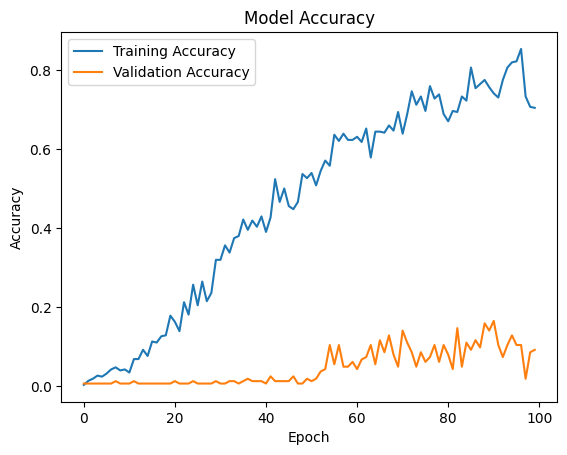

In [ ]:
def cnn_model(train_dir,test_dir,target_size=(128,128),batch_size=32,epochs=100):
    #Enhanced Data Augmentation for Training Set
    train_datagen=ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.8, 1.2]
    )

    #Training Data Generator
    train_generator=train_datagen.flow_from_directory(
        train_dir,
        shuffle=False,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    #Test Data Generator
    test_datagen=ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.8, 1.2]
      )
    test_generator=test_datagen.flow_from_directory(
        test_dir,
        shuffle=False,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    #CNN Model
    model=Sequential()
    #First Convolutional Block
    model.add(Input(shape=(target_size[0],target_size[1],3)))
    model.add(Conv2D(32,(3,3),activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    #Second Convolutional Block
    model.add(Conv2D(64,(3,3),activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    #Third Convolutional Block
    model.add(Conv2D(128,(3,3),activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    #Fourth Convolutional Block
    model.add(Conv2D(256,(3,3),activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    #Global Average Pooling and Fully Connected Layer
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))

    #Output Layer
    model.add(Dense(train_generator.num_classes,activation='softmax'))

    #Compile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

    #Train the model
    history=model.fit(
        train_generator,
        steps_per_epoch=len(train_generator)//train_generator.batch_size,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=len(test_generator)//test_generator.batch_size
    )

    #Save the model
    model.save('signature_recognition_model.h5')
    #Evaluate the model on the test set
    loss,accuracy=model.evaluate(test_generator)
    print(f'Test accuracy: {accuracy*100:.2f}%')
    return history,model

#Plotting the training and validation accuracy
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='Training Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

# Example of how to call the function
train_dir='/content/signatures_directory/train/'
test_dir='/content/signatures_directory/test/'
history,model=cnn_model(train_dir,test_dir,epochs=100)

#Plot the accuracies
plot_accuracy(history)

Part 2 : Use Pre trained CNN weights like Resnet to see the difference

In [ ]:
def cnn_model_resnet(train_dir,test_dir,target_size=(128,128),batch_size=32,epochs=100):
    #Enhanced Data Augmentation for Training Set
    train_datagen=ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.8, 1.2]
    )

    #Training Data Generator
    train_generator=train_datagen.flow_from_directory(
        train_dir,
        shuffle=False,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    #Test Data Generator
    test_datagen=ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.8,1.2]
    )

    test_generator=test_datagen.flow_from_directory(
        test_dir,
        shuffle=False,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    #Pretrained ResNet50 Model
    base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(target_size[0],target_size[1],3))

    #Freeze the base model's layers
    for layer in base_model.layers:
        layer.trainable=False

    #Building the Model
    model=Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.5),
        Dense(train_generator.num_classes,activation='softmax')  # Output layer for classification
    ])

    #Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

    #Train the model
    history=model.fit(
        train_generator,
        steps_per_epoch=len(train_generator)//train_generator.batch_size,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=len(test_generator)//test_generator.batch_size
    )

    #Save the model
    model.save('signature_recognition_model_resnet.h5')

    #Evaluate the model on the test set
    loss,accuracy=model.evaluate(test_generator)
    print(f'Test accuracy: {accuracy * 100:.2f}%')
    return history,model

#Plotting the training and validation accuracy
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='Training Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

# Example of how to call the function
train_dir='/content/signatures_directory/train/'
test_dir='/content/signatures_directory/test/'
history,model=cnn_model_resnet(train_dir,test_dir,epochs=100)

#Plot the accuracies
plot_accuracy(history)

Found 382 images belonging to 158 classes.
Found 164 images belonging to 158 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.0000e+00 - loss: 9.1584 - val_accuracy: 0.0122 - val_loss: 7.2439
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.0042 - loss: 6.9354 - val_accuracy: 0.0061 - val_loss: 5.9560
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.0000e+00 - loss: 5.7731 - val_accuracy: 0.0122 - val_loss: 5.4095
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.0066 - loss: 5.3072 - val_accuracy: 0.0122 - val_loss: 5.2113
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.0098 - loss: 5.1384 - val_accuracy: 0.0122 - val_loss: 5.1649
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.0267 - loss: 5.0603 - val_accuracy: 0.0122 - val_loss: 5.1561
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.0186 - loss: 5.0426 - val_accuracy: 0.0122 - val_loss: 5.1637
Epoch 8/100
 4/12 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.0595 - loss: 4.9977

Part 3 : Use HOG for Feature Extraction

Found 382 images belonging to 159 classes.
Found 164 images belonging to 159 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 4.0274e-04 - loss: 12.1718 - val_accuracy: 0.0061 - val_loss: 11.8347
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0808 - loss: 10.5655 - val_accuracy: 0.0061 - val_loss: 11.5909
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.1650 - loss: 9.4855 - val_accuracy: 0.0122 - val_loss: 11.1029
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3196 - loss: 8.5308 - val_accuracy: 0.0061 - val_loss: 10.5753
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4447 - loss: 7.7379 - val_accuracy: 0.0061 - val_loss: 10.1081
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5592 - loss: 6.9769 - val_accuracy: 0.0122 - val_loss: 9.5959
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6741 - loss: 6.4034 - val_accuracy: 0.0122 - val_loss: 9.1403
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7458 - loss: 5.7999 - val_a

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1754 - loss: 5.0895 
Test accuracy: 17.68%


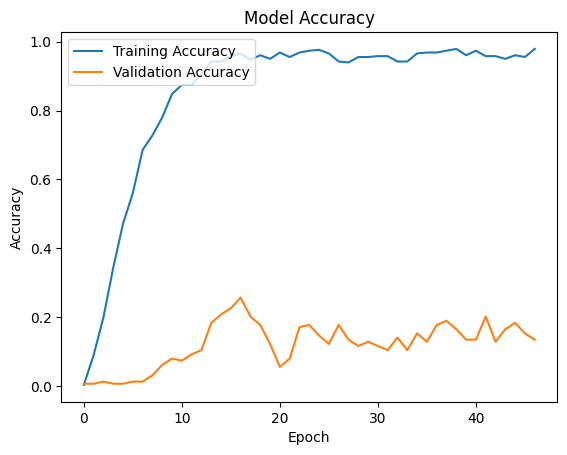

In [ ]:
#Function to extract HOG features from an image
def extract_hog_features(image,target_size=(128,128)):
    #Resize the image to the target size
    image_resized=resize(image,target_size)
    #Convert the image to grayscale
    image_gray=color.rgb2gray(image_resized)
    #Extract HOG features
    features,_=hog(image_gray,pixels_per_cell=(8,8),cells_per_block=(2,2),visualize=True)
    return features


#Function to extract HOG features from the entire dataset
def extract_features(generator,target_size=(128,128)):
    features=[]
    labels=[]
    for batch,label_batch in generator:
        for i in range(batch.shape[0]):
            image=batch[i]
            hog_features=extract_hog_features(image,target_size)
            features.append(hog_features)
            labels.append(label_batch[i])
        #Break after one complete epoch
        if len(features)>=generator.samples:
            break
    return np.array(features),np.array(labels)

def hog_model(train_dir,test_dir,target_size=(128,128),batch_size=32,epochs=200):
    #Data Generators
    train_datagen=ImageDataGenerator(rescale=1./255)
    test_datagen=ImageDataGenerator(rescale=1./255)
    train_generator=train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    test_generator=test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    #Extract HOG features for both training and testing data
    x_train,y_train=extract_features(train_generator,target_size)
    x_test,y_test=extract_features(test_generator,target_size)

    #MLP Model
    model=Sequential()
    #Fully Connected Layer 1
    model.add(Dense(256,input_dim=x_train.shape[1],activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    #Fully Connected Layer 2
    model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    #Output Layer
    model.add(Dense(train_generator.num_classes,activation='softmax'))

    #Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

    #Train the model
    history=model.fit(
        x_train,y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test,y_test),
        callbacks=[EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)]
    )

    #Save the model
    model.save('hog_signature_recognition_model.h5')

    #Evaluate the model on the test set
    loss,accuracy=model.evaluate(x_test,y_test)
    print(f'Test accuracy: {accuracy*100:.2f}%')
    return history,model

#Plotting function remains the same
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='Training Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()


train_dir='/content/signatures_directory/train/'
test_dir='/content/signatures_directory/test/'
history,model=hog_model(train_dir,test_dir,epochs=200)

#Plot the accuracies
plot_accuracy(history)


Part 4 : Use SIFT for Feature Extraction

Found 382 images belonging to 159 classes.
Found 164 images belonging to 159 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.0055 - loss: 11.9973 - val_accuracy: 0.0122 - val_loss: 14.4560
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.0220 - loss: 10.0168 - val_accuracy: 0.0183 - val_loss: 11.5768
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.0427 - loss: 9.3450 - val_accuracy: 0.0061 - val_loss: 10.1804
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.1013 - loss: 8.4988 - val_accuracy: 0.0122 - val_loss: 9.3449
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.1458 - loss: 7.7785 - val_accuracy: 0.0305 - val_loss: 8.7754
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.2512 - loss: 7.1391 - val_accuracy: 0.0244 - val_loss: 8.4165
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3149 - loss: 6.7399 - val_accuracy: 0.0122 - val_loss: 8.2271
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3423 - loss: 6.4339 - val_accurac

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0341 - loss: 6.3856
Test accuracy: 4.27%


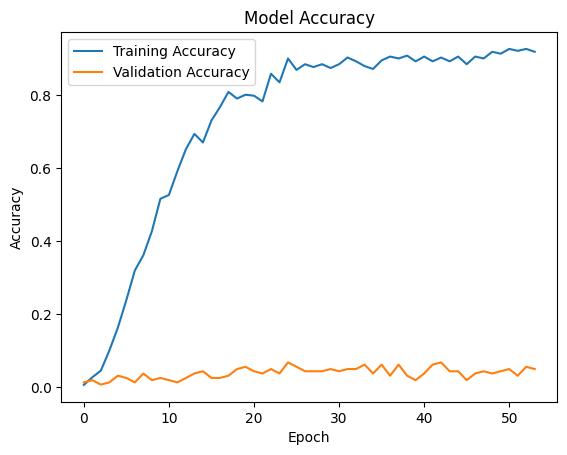

In [ ]:
def extract_sift_features(image,target_size=(128,128),n_features=100):
    image_resized=cv2.resize(image,target_size)
    image_gray=cv2.cvtColor(image_resized,cv2.COLOR_RGB2GRAY)
    image_gray_uint8=(image_gray*255).astype(np.uint8)
    sift=cv2.SIFT_create(nfeatures=n_features)
    keypoints,descriptors=sift.detectAndCompute(image_gray_uint8,None)
    if descriptors is None:
        return np.zeros((n_features,128)).flatten()
    if descriptors.shape[0]<n_features:
        pad_size=n_features-descriptors.shape[0]
        descriptors=np.pad(descriptors,((0,pad_size),(0,0)),'constant')
    elif descriptors.shape[0]>n_features:
        descriptors=descriptors[:n_features,:]
    return descriptors.flatten()



def extract_features(generator,target_size=(128,128),n_features=100):
    features=[]
    labels=[]
    for batch,label_batch in generator:
        for i in range(batch.shape[0]):
            image=batch[i]
            sift_features=extract_sift_features(image,target_size,n_features)
            features.append(sift_features)
            labels.append(label_batch[i])
        if len(features) >= generator.samples:
            break
    return np.array(features),np.array(labels)


def sift_model(train_dir,test_dir,target_size=(128,128),batch_size=32,epochs=200,n_features=100):
    train_datagen=ImageDataGenerator(rescale=1./255)
    test_datagen=ImageDataGenerator(rescale=1./255)

    train_generator=train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator=test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    x_train,y_train=extract_features(train_generator,target_size,n_features)
    x_test,y_test=extract_features(test_generator,target_size,n_features)

    #MLP Model
    model=Sequential()
    #Fully Connected Layer 1
    model.add(Dense(256,input_dim=x_train.shape[1],activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    #Fully Connected Layer 2
    model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    #Output Layer
    model.add(Dense(train_generator.num_classes,activation='softmax'))
    #Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

    #Train the model
    history=model.fit(
        x_train,y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test,y_test),
        callbacks=[EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)]
    )

    #Save the model
    model.save('sift_signature_recognition_model.h5')
    loss,accuracy=model.evaluate(x_test,y_test)
    print(f'Test accuracy: {accuracy*100:.2f}%')
    return history,model


def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='Training Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

train_dir='/content/signatures_directory/train/'
test_dir='/content/signatures_directory/test/'
history,model=sift_model(train_dir,test_dir,epochs=200,n_features=100)

#Plot the accuracies
plot_accuracy(history)

In [2]:
!unzip /content/Data.zip -d /content/Data

Archive:  /content/Data.zip
  inflating: /content/Data/Data/20240904_083201.jpg  
  inflating: /content/Data/Data/20240904_083217.jpg  
  inflating: /content/Data/Data/20240904_083233.jpg  
  inflating: /content/Data/Data/20240904_083248.jpg  
  inflating: /content/Data/Data/20240904_083305.jpg  
  inflating: /content/Data/Data/20240904_083320.jpg  
  inflating: /content/Data/Data/20240904_083334.jpg  
  inflating: /content/Data/Data/20240904_083350.jpg  
  inflating: /content/Data/Data/20240904_083411.jpg  
  inflating: /content/Data/Data/20240904_083435.jpg  
  inflating: /content/Data/Data/20240904_091404.jpg  
  inflating: /content/Data/Data/20240904_091434.jpg  
  inflating: /content/Data/Data/20240904_091442.jpg  
  inflating: /content/Data/Data/20240904_091451.jpg  
  inflating: /content/Data/Data/20240904_091501.jpg  
  inflating: /content/Data/Data/20240904_091509.jpg  
